# Results for paper: TITLE

This notebook contains the script used to create results for *link*

## Cyclohexane

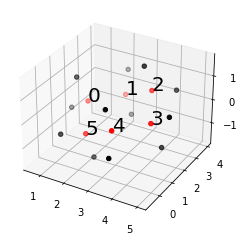

In [1]:
# The carbon atoms are arranged in the correct order to move along the ring.
cyclohexane_xyz = """
C      1.367908000      1.836044000     -0.049671000
C      2.329589000      3.011988000     -0.044238000
C      3.630888000      2.632672000      0.661249000
C      4.247092000      1.383956000      0.049671000
C      3.285411000      0.208012000      0.044238000
C      1.984112000      0.587328000     -0.661249000
H      2.524936000      3.113740000     -0.900292000
H      1.933922000      3.936128000      0.506802000
H      3.388552000      2.469096000      1.674854000
H      4.348450000      3.220000000      0.605369000
H      1.030575000      1.607424000      0.972471000
H      0.592407000      1.921052000     -0.581309000
H      4.584425000      1.612576000     -0.972471000
H      5.022593000      1.298948000      0.581309000
H      2.226448000      0.750904000     -1.674854000
H      1.266550000     -0.000000000     -0.605369000
H      3.090064000      0.106260000      0.900292000
H      3.681078000     -0.716128000     -0.506802000
"""

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import interactive
interactive(True)

# Uncomment to get an interactive plot 
# %matplotlib qt

x,y,z = [],[],[]
carbons = 6
cyclohexane = cyclohexane_xyz.split('\n')[1:-1]
for line in cyclohexane:
    items = line.split("     ")
    x.append(float(items[1]))
    y.append(float(items[2]))
    z.append(float(items[3]))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x[:6], y[:6], z[:6], c="red")
ax.scatter(x[6:], y[6:], z[6:], c="black")
for i in range(carbons):
    ax.text(x[i],y[i],z[i], '%s' %(str(i)), size=20, zorder=1, color='k')
plt.show()

In [2]:
# from nbed.mol_plot import draw_molecule

# mol_view = draw_molecule(cyclohexane,
#               width=400,
#                height=400,
#               jupyter_notebook=True)
# mol_view.show()

# Cyclohexane

## Reference Values 

In [3]:
# from pyscf import scf, cc

# print("Whole system DFT")
# ks = scf.RKS(molecule)
# ks.conv_tol = config["convergence"]
# ks.xc = config["xc_functional"]
# whole_dft = ks.kernel()
# print("")

# print("Hartree Fock")
# hf = scf.RHF(molecule)
# hf.conv_tol = config["convergence"]
# hf_energy = hf.kernel()
# print("")

# print("CCSD")
# ccsd = cc.CCSD(hf)
# ccsd.conv_tol = config["convergence"]
# whole_ccsd, *_ = ccsd.kernel()
# whole_ccsd += hf_energy

In [5]:
from nbed.utils import save_ordered_xyz_file, pubchem_mol_geometry
from pathlib import Path

def find_and_save(mol_name):
    savefile = f'./molecular_structures/{mol_name}.xyz'

    if Path(savefile).exists():
        print(f'{savefile} already exists.\n')
        return

    geo_dict = pubchem_mol_geometry(mol_name)
    save_ordered_xyz_file(mol_name, geo_dict, [0], save_location=savefile)
    print(f'{savefile} created.')

In [6]:
from openfermion import get_sparse_operator
from scipy.sparse.linalg import eigsh

def diagonalize(hamiltonian):
    sparse_ham = get_sparse_operator(hamiltonian)
    eigenvalues, _ = eigsh(sparse_ham)
    return eigenvalues[0]

In [9]:
from pathlib import Path
from pyscf.gto import Mole
import nbed
from nbed.driver import NbedDriver
from nbed.ham_builder import HamiltonianBuilder
from nbed.ham_converter import HamiltonianConverter
from openfermion import count_qubits
import json

localisation = ['spade','mullikan','boys','ipo']

# Need to build paths to xyz files.
max_atoms = 3

def get_results(mol_name, n_active_atoms, localisation='pipek-mezey', qubits=None):
    find_and_save(mol_name)
    geometry = f'./molecular_structures/{mol_name}.xyz'

    result = {}
    # We pass these to the driver.
    result['n_active_atoms']=n_active_atoms
    result['localization']=localisation
    result['basis']='sto-3g'
    result['xc_functional']='b3lyp'
    result['convergence']=1e-6
    result['savefile']=None
    result['charge']=0
    result['mu_level_shift']=1e6
    result['run_ccsd_emb']=True
    result['run_fci_emb']=False
    result['max_ram_memory']=8_000
    result['pyscf_print_level']=1

    driver = NbedDriver(geometry=geometry, projector='both', **result)
    result['e_dft'] = driver._global_rks.e_tot

    # These are important but not used in the driver.
    result['mol_name']=mol_name
    result['transform']='jordan_wigner'
    result['qubits'] = qubits

    # Mu shift result
    mu_builder = HamiltonianBuilder(driver._mu['scf'], driver._mu['classical_energy'], transform=result['transform'])
    result['mu'] = {}
    qham = mu_builder.build(qubits)
    result['mu']['qham'] = HamiltonianConverter(qham)._intermediate
    result['mu']['terms'] = len(qham.terms)
    result['mu']['n_qubits'] = count_qubits(qham)
    result['mu']['classical_energy'] = driver._mu['classical_energy']
    result['mu']['e_ccsd'] = driver._mu['e_ccsd']

    # Huzinaga result
    huz_builder = HamiltonianBuilder(driver._huzinaga['scf'], driver._huzinaga['classical_energy'], transform=result['transform'])
    result['huz'] = {}
    qham = huz_builder.build(qubits)
    result['huz']['qham'] = HamiltonianConverter(qham)._intermediate
    result['huz']['terms'] = len(qham.terms)
    result['huz']['n_qubits'] = count_qubits(qham)
    result['huz']['classical_energy'] = driver._huzinaga['classical_energy']
    result['huz']['e_ccsd'] = driver._huzinaga['e_ccsd']

    full_ham = HamiltonianBuilder(driver._global_hf, transform=result['transform']).build()
    result['full_terms'] = len(full_ham.terms)
    result['full_n_qubits'] = count_qubits(full_ham)
    result['full_qham'] = HamiltonianConverter(full_ham)._intermediate

    print(f'DFT Energy: {result["e_dft"]}')
    print(f"Mu CCSD Embedding energy {result['mu']['e_ccsd']}")
    print(f"Huz CCSD Embedding energy {result['huz']['e_ccsd']}")

    print(f"Qubits used {result['mu']['n_qubits']}/{result['huz']['n_qubits']}/{result['full_n_qubits']}")
    print(f"Number of terms {result['mu']['terms']}/{result['huz']['terms']}/{result['full_terms']}")

    savefile = f'../data/{mol_name}_{n_active_atoms}_{localisation}.json'
    with open(savefile, 'w') as f:
        json.dump(result, f, indent=4)
        print(f'{savefile} created.')

    return result


In [12]:
water = get_results("water", 1)

./molecular_structures/water.xyz already exists.

DFT Energy: -75.27815045263158
Mu CCSD Embedding energy -75.12163273377055
Huz CCSD Embedding energy -75.12163243153518
Qubits used 6/6/10
Number of terms 118/118/356
../data/water_1_pipek-mezey.json created.


In [13]:
HC = HamiltonianConverter

print(f"Mu Energy: {diagonalize(water['mu']['qham'])}")
print(f"Huz Energy: {diagonalize(water['huz']['qham'])}")
print(f"Full Energy: {diagonalize(water['full_qham'])}")

TypeError: Failed to convert a dict to a sparse matrix.

Cycle through molecules to output the desired info.

In [9]:
from pyscf import scf, cc, gto

molecule = gto.Mole(atom=geometry, charge=0).build()

print("Whole system DFT")
ks = scf.RKS(molecule)
ks.conv_tol = convergence
ks.xc = xc_functional
whole_dft = ks.kernel()
print("")

print("Hartree Fock")
hf = scf.RHF(molecule)
hf.conv_tol = convergence
hf_energy = hf.kernel()
print("")

print("CCSD")
ccsd = cc.CCSD(hf)
ccsd.conv_tol = convergence
whole_ccsd, *_ = ccsd.kernel()
whole_ccsd += hf_energy

Whole system DFT
converged SCF energy = -116.386569879701

Hartree Fock
converged SCF energy = -115.66607486168

CCSD
E(CCSD) = -115.8731272952766  E_corr = -0.2070524335969255


In [10]:
from openfermion import eigenspectrum
from openfermion import count_qubits

active_atoms = [i for i in range(0,4)]
#energies = [eigenspectrum(qham)[0] for qham in qhams.values()]
#n_qubits = [count_qubits(qham) for qham in qhams.values()]

energies = [whole_dft] + [eigenspectrum(qham)[0] for qham in qhams.values()]
n_qubits = [0] + [count_qubits(qham) for qham in qhams.values()]


TypeError: Failed to convert a dict to a sparse matrix.

[-75.12311562350982, -75.06244449494378]

/home/mwilliams/anaconda3/envs/nbed/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


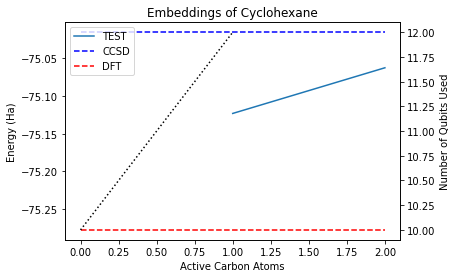

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.set_ylabel('Number of Qubits Used')
ax2.plot(n_qubits, linestyle='dotted', color='black')

ax.hlines(whole_ccsd, 0, 2, colors='blue', linestyle='dashed', label='CCSD')
ax.hlines(whole_dft, 0, 2, colors='red', linestyle='dashed', label='DFT')
ax.plot(active_atoms, energies, label='TEST')
ax.set_xlabel('Active Carbon Atoms')
ax.set_ylabel('Energy (Ha)')
ax.set_title('Embeddings of Cyclohexane')
ax.legend()
fig.show()